In [1]:
#Import Libraries
import pandas as pd
import os
import matplotlib.pyplot as plt

import findspark
from pyspark.sql import SparkSession
from pyspark.ml.classification import LogisticRegression
from lib_file import lib_path


from pyspark.sql import functions as F
from pyspark.sql.window import Window

In [2]:
#Find the Spark is installed or not
findspark.init()
findspark

<module 'findspark' from 'C:\\Users\\Sneha Dharne\\anaconda3\\envs\\myproject\\lib\\site-packages\\findspark.py'>

In [3]:
from pyspark import SparkContext

sc = SparkContext.getOrCreate()
print(sc)
print(sc.version)


<SparkContext master=local[*] appName=pyspark-shell>
3.5.1


In [4]:
#Need to install java and pyspark then set env in system and here
os.environ["JAVA_HOME"] = "C:/Program Files/Java/jdk-1.8"
os.environ["SPARK_HOME"] = "C:/Users/Sneha Dharne/anaconda3/envs/MyProjcect/Lib/site-packages/pyspark"

In [5]:
#Start the session for acces the spark lib
spark = SparkSession.builder.appName('Global_Temprature').getOrCreate()

In [6]:
# Data Loading with spark
data1 = spark.read.csv('Datasets/GlobalLandTemperaturesByCity.csv', inferSchema = True, header = True)

In [7]:
# Preliminary Analysis
data1.printSchema()

root
 |-- dt: date (nullable = true)
 |-- AverageTemperature: double (nullable = true)
 |-- AverageTemperatureUncertainty: double (nullable = true)
 |-- City: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Latitude: string (nullable = true)
 |-- Longitude: string (nullable = true)



In [8]:
data1.show(10)

+----------+------------------+-----------------------------+-----+-------+--------+---------+
|        dt|AverageTemperature|AverageTemperatureUncertainty| City|Country|Latitude|Longitude|
+----------+------------------+-----------------------------+-----+-------+--------+---------+
|1743-11-01|             6.068|           1.7369999999999999|Århus|Denmark|  57.05N|   10.33E|
|1743-12-01|              NULL|                         NULL|Århus|Denmark|  57.05N|   10.33E|
|1744-01-01|              NULL|                         NULL|Århus|Denmark|  57.05N|   10.33E|
|1744-02-01|              NULL|                         NULL|Århus|Denmark|  57.05N|   10.33E|
|1744-03-01|              NULL|                         NULL|Århus|Denmark|  57.05N|   10.33E|
|1744-04-01|5.7879999999999985|           3.6239999999999997|Århus|Denmark|  57.05N|   10.33E|
|1744-05-01|            10.644|           1.2830000000000001|Århus|Denmark|  57.05N|   10.33E|
|1744-06-01|14.050999999999998|                   

In [9]:
from pyspark.sql.functions import to_timestamp

data1 = data1.withColumn("dt", to_timestamp("dt")) # Convert 'dt' column to timestamp
data1.printSchema()

root
 |-- dt: timestamp (nullable = true)
 |-- AverageTemperature: double (nullable = true)
 |-- AverageTemperatureUncertainty: double (nullable = true)
 |-- City: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Latitude: string (nullable = true)
 |-- Longitude: string (nullable = true)



In [10]:
# Sort the DataFrame by the 'dt' column
data1 = data1.orderBy('dt')

#Create a new column that represents the first day of the month for each row (monthly frequency)
data1 = data1.withColumn('month_start', F.trunc('dt', 'MM'))

#Group by the 'month_start' and calculate the average temperature for each month
data_monthly = data1.groupBy('month_start').agg(
    F.avg('AverageTemperature').alias('AverageTemperature')
)


window_spec = Window.orderBy('month_start')

data_monthly = data_monthly.withColumn(
    'AverageTemperature',
    F.last('AverageTemperature', True).over(window_spec)  # Handling Missing Values using forward fill
)

# Show the result
data_monthly.show(20)


+-----------+-------------------+
|month_start| AverageTemperature|
+-----------+-------------------+
| 1743-11-01|  4.882423512747881|
| 1743-12-01|  4.882423512747881|
| 1744-01-01|  4.882423512747881|
| 1744-02-01|  4.882423512747881|
| 1744-03-01|  4.882423512747881|
| 1744-04-01|  9.737433427762047|
| 1744-05-01| 12.685514164305946|
| 1744-06-01| 16.868296033994334|
| 1744-07-01| 18.844524079320134|
| 1744-08-01| 18.844524079320134|
| 1744-09-01| 14.316601983002855|
| 1744-10-01|  8.719062322946183|
| 1744-11-01|   4.63659206798867|
| 1744-12-01| 0.0643512747875354|
| 1745-01-01| -2.257733711048156|
| 1745-02-01|-1.3594759206798872|
| 1745-03-01| 1.9162152974504254|
| 1745-04-01| 7.6913654390934845|
| 1745-05-01| 7.6913654390934845|
| 1745-06-01| 7.6913654390934845|
+-----------+-------------------+
only showing top 20 rows



In [11]:
null_counts = data_monthly.select([F.sum(F.col(c).isNull().cast("int")).alias(c) for c in data_monthly.columns])

# Show the result
null_counts.show()

+-----------+------------------+
|month_start|AverageTemperature|
+-----------+------------------+
|          0|                 0|
+-----------+------------------+



In [12]:
#Filter data for January 2013 (date filtering)
data_monthly_2013 = data_monthly.filter(F.col('month_start') >= '2013-01-01')

# Show the result
data_monthly_2013.show(5)

+-----------+------------------+
|month_start|AverageTemperature|
+-----------+------------------+
| 2013-01-01|  11.5676515669516|
| 2013-02-01|13.144058689458632|
| 2013-03-01|15.551185470085478|
| 2013-04-01|18.668117378917373|
| 2013-05-01|21.748557549857487|
+-----------+------------------+
only showing top 5 rows



In [13]:
data_monthly = data_monthly.dropna()

In [14]:
# Data Pre-processing
# Performing the Augmented Dickey-Fuller (ADF) Test for Stationarity

from statsmodels.tsa.stattools import adfuller

#Extract data into Pandas for the ADF test
data_pandas = data_monthly.select('AverageTemperature').toPandas()

#Perform the ADF test
result = adfuller(data_pandas['AverageTemperature'])

#Print the ADF test results
print('ADF Statistic:', result[0])
print('p-value:', result[1])
for key, value in result[4].items():
    print('Critical Values:', key, value)

#Interpret the results
if result[1] < 0.05:
    print("The series is stationary (reject the null hypothesis of a unit root).")
else:
    print("The series is not stationary (fail to reject the null hypothesis of a unit root).")

ADF Statistic: -2.3016048267538256
p-value: 0.17145090535811808
Critical Values: 1% -3.4323875260668344
Critical Values: 5% -2.862440255934873
Critical Values: 10% -2.5672492261933377
The series is not stationary (fail to reject the null hypothesis of a unit root).


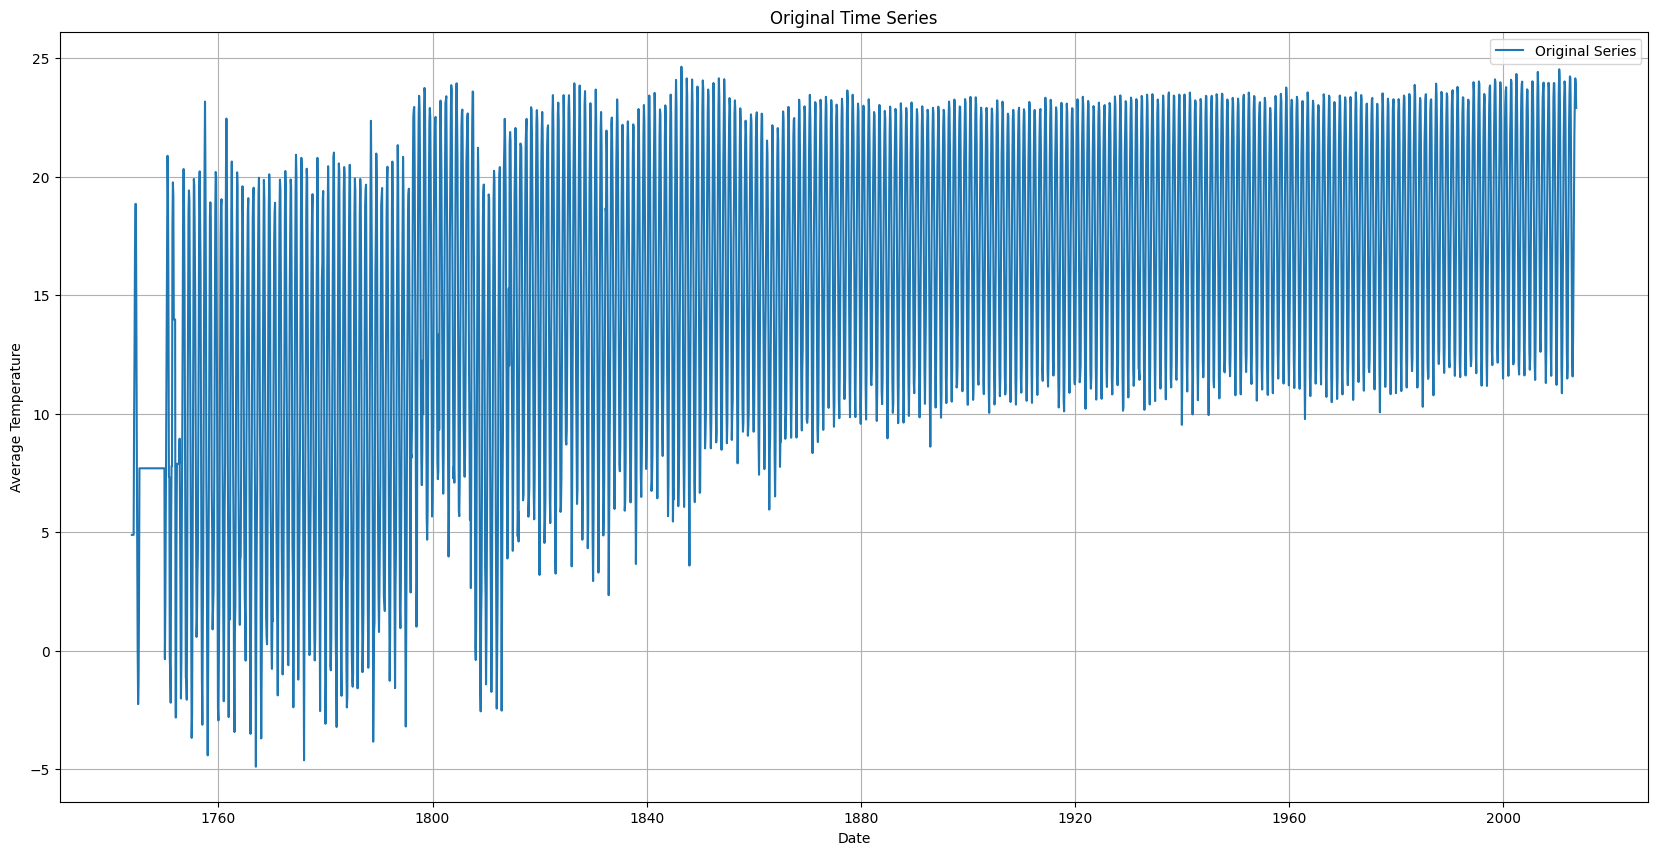

In [15]:
# Convert the PySpark DataFrame to Pandas DataFrame
data_pandas = data_monthly.select('month_start', 'AverageTemperature').toPandas()

# Use 'month_start' as the date and create a datetime index
data_pandas['Date'] = pd.to_datetime(data_pandas['month_start'])

# Plot the time series
plt.figure(figsize=(20.5, 10))
plt.plot(data_pandas['Date'], data_pandas['AverageTemperature'], label='Original Series')
plt.title('Original Time Series')
plt.xlabel('Date')
plt.ylabel('Average Temperature')
plt.legend()
plt.grid(True)
plt.show()


In [16]:
# Stationarity Testing Using First-Order Differencing in PySpark

from pyspark.sql.functions import col, lag, when


#Apply first-order differencing
# Create a window specification to calculate the lagged values
window_spec = Window.orderBy("month_start")

# Calculate the difference between the current and previous row
data_diff = data_monthly.withColumn(
    "DifferencedTemperature",
    col("AverageTemperature") - lag("AverageTemperature", 1).over(window_spec)
).dropna()

#Perform the ADF test on the differenced data
data_diff_pandas = data_diff.select("DifferencedTemperature").toPandas()
result_diff = adfuller(data_diff_pandas["DifferencedTemperature"])

#Print the test results
print('ADF Statistic (differenced):', result_diff[0])
print('p-value (differenced):', result_diff[1])
for key, value in result_diff[4].items():
    print('Critical Values:', key, value)

#Interpret the results
if result_diff[1] < 0.05:
    print("The differenced series is stationary (reject the null hypothesis of a unit root).")
else:
    print("The differenced series is still not stationary (fail to reject the null hypothesis of a unit root).")


ADF Statistic (differenced): -12.773706630274775
p-value (differenced): 7.673452021517342e-24
Critical Values: 1% -3.4323900686602644
Critical Values: 5% -2.8624413789638763
Critical Values: 10% -2.567249824072145
The differenced series is stationary (reject the null hypothesis of a unit root).


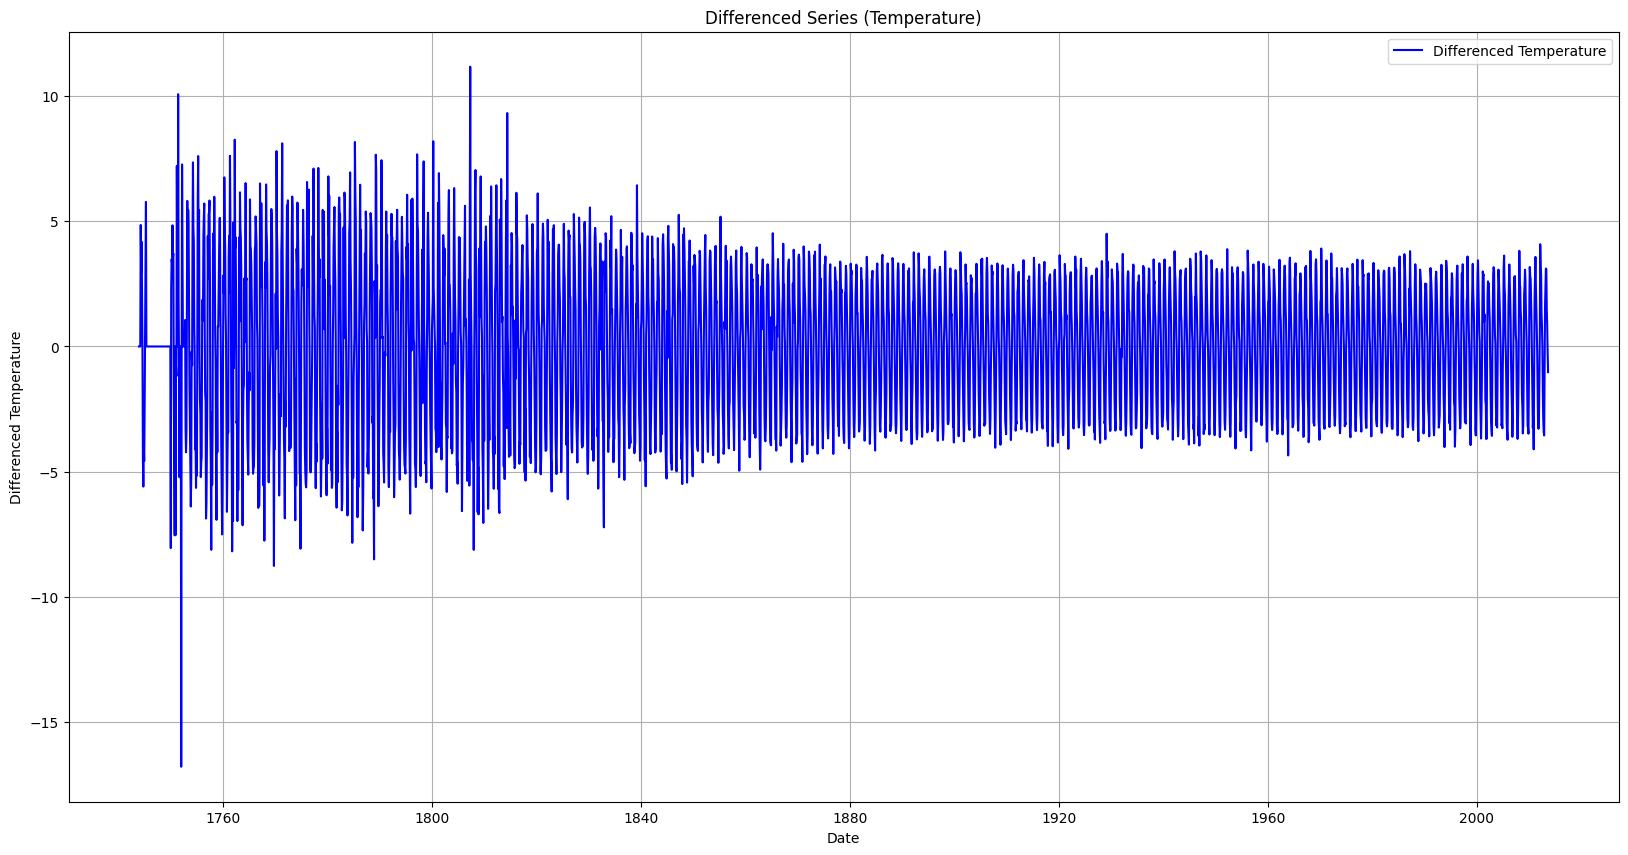

In [17]:
#Convert the PySpark DataFrame with the differenced data to Pandas
data_diff_pandas = data_diff.select("month_start", "DifferencedTemperature").toPandas()

# Ensure 'month_start' is in datetime format for proper plotting
data_diff_pandas["month_start"] = pd.to_datetime(data_diff_pandas["month_start"])

#Set 'month_start' as the index for easier plotting
data_diff_pandas.set_index("month_start", inplace=True)

#Plot the differenced series
plt.figure(figsize=(20, 10))
plt.plot(data_diff_pandas.index, data_diff_pandas["DifferencedTemperature"], label="Differenced Temperature", color="blue")
plt.title("Differenced Series (Temperature)")
plt.xlabel("Date")
plt.ylabel("Differenced Temperature")
plt.grid()
plt.legend()
plt.show()

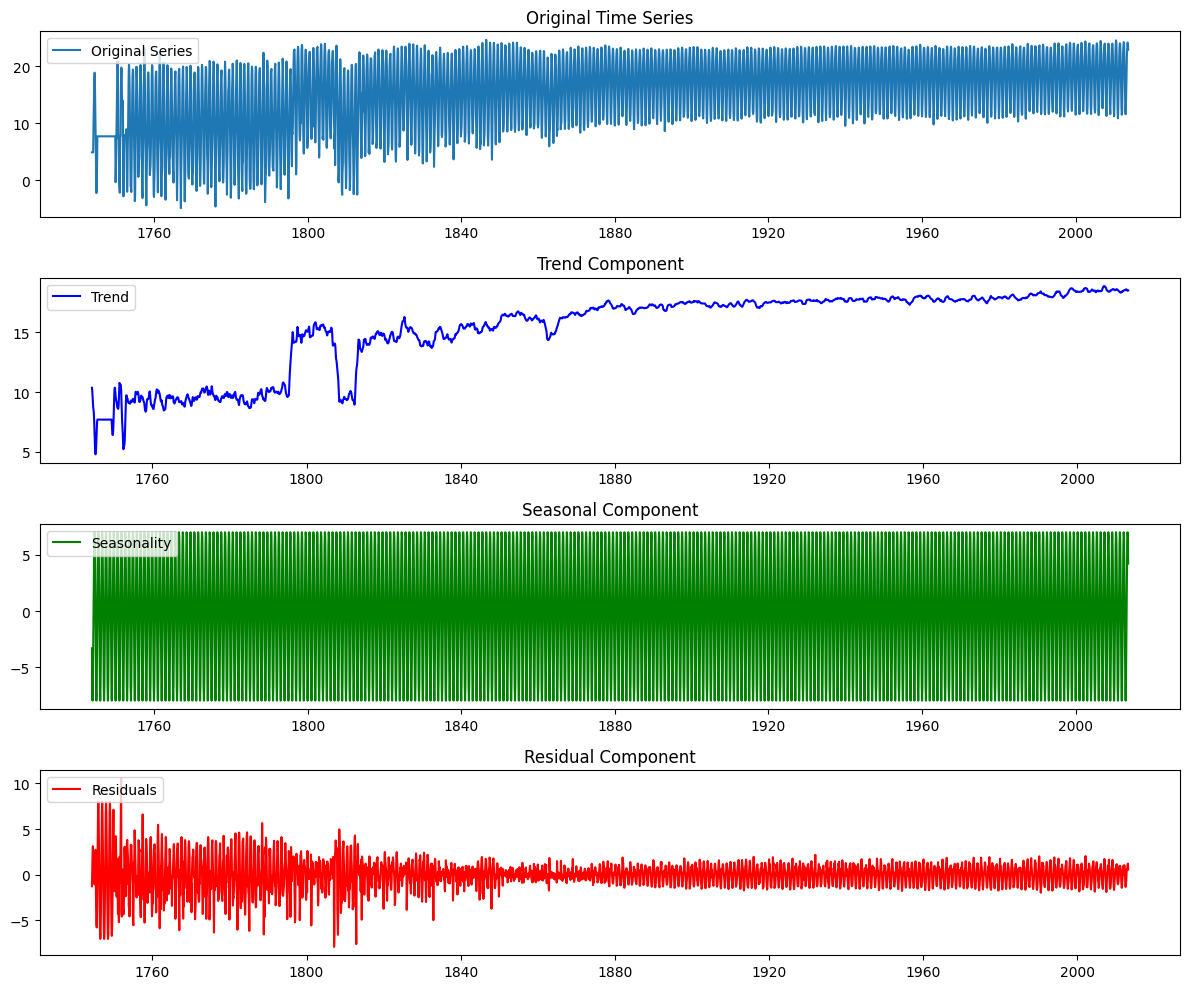

In [18]:
# Checking Time Series

from statsmodels.tsa.seasonal import seasonal_decompose

# Convert the PySpark DataFrame to Pandas DataFrame
data_pandas = data_monthly.select('month_start', 'AverageTemperature').toPandas()

# Use 'month_start' as the date and create a datetime index
data_pandas['Date'] = pd.to_datetime(data_pandas['month_start'])
data_pandas.set_index('Date', inplace=True)

# Perform seasonal decomposition on 'AverageTemperature'
decomposition = seasonal_decompose(data_pandas['AverageTemperature'], model='additive', period=12)

# Extract components
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot the decomposition components
plt.figure(figsize=(12, 10))

# Original Series
plt.subplot(4, 1, 1)
plt.plot(data_pandas['AverageTemperature'], label='Original Series')
plt.legend(loc='upper left')
plt.title('Original Time Series')

# Trend
plt.subplot(4, 1, 2)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='upper left')
plt.title('Trend Component')

# Seasonality
plt.subplot(4, 1, 3)
plt.plot(seasonal, label='Seasonality', color='green')
plt.legend(loc='upper left')
plt.title('Seasonal Component')

# Residuals
plt.subplot(4, 1, 4)
plt.plot(residual, label='Residuals', color='red')
plt.legend(loc='upper left')
plt.title('Residual Component')

plt.tight_layout()
plt.show()


In [35]:
# Save Preprocessing Model
# Define the output file path
output_path = "D:/thesis_code_sneha/data_monthly.csv"

# Remove the file if it already exists
if os.path.exists(output_path):
    os.remove(output_path)

# Convert PySpark DataFrame to pandas DataFrame
data_monthly_pd = data_monthly.toPandas()

# Save pandas DataFrame to a CSV file
data_monthly_pd.to_csv(output_path, index=False)

---